In [21]:
%load_ext autoreload
%autoreload 2

from tweedejaars_project import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import *
from sklearn import metrics

df = load_df()

version = "target"
target = "fix_two_sided_ptu"
train_set = "train"
test_set = "valid"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
df['residual_load'] = df['forecast_demand'] - df['forecast_solar'] - df['forecast_wind']
df['forecast_solar_delta'] = df['forecast_solar'].diff()
df['forecast_wind_delta'] = df['forecast_wind'].diff()
for i in range(0, len(df), 15):
    df.loc[i+1:i+14, 'forecast_solar_delta'] = df['forecast_solar_delta'][i]
    df.loc[i+1:i+14, 'forecast_wind_delta'] = df['forecast_wind_delta'][i]
# diffs
df['min_price_diff'] = df['min_price_published'].diff() + df['min_price_published']
df['downward_dispatch_diff'] = df['downward_dispatch_published'].diff() + df['downward_dispatch_published']
df['igcc_down_diff'] = df['igcc_contribution_down_published'].diff() + df['igcc_contribution_down_published']
df['downward_dispatch_diff_2'] = df['downward_dispatch_published'].diff(periods=2) + df['downward_dispatch_published']
df['downward_dispatch_diff_3'] = df['downward_dispatch_published'].diff(periods=3) + df['downward_dispatch_published']
df['dispatch_diff'] = df['upward_dispatch_published'] - df['downward_dispatch_published']
df['igcc_diff'] = df['igcc_contribution_up_published'] - df['igcc_contribution_down_published']
df['import_zero'] = df['import_capacity'] == 0
df['import_capacity_left'] = df['import_capacity'] + df['igcc_contribution_down_published'] - df['igcc_contribution_up_published']

In [23]:
df['downward_dispatch_peak'] = (df['downward_dispatch_published'] < df['downward_dispatch_published'].shift(1)) & \
                       (df['downward_dispatch_published'].shift(1) > df['downward_dispatch_published'].shift(2))

df['downward_dispatch_peak_time'] = df['downward_dispatch_peak'].cumsum()
df['downward_dispatch_peak_time'] = df.groupby('downward_dispatch_peak_time').cumcount() + 1

df['peak_values'] = np.where(df['downward_dispatch_peak'], df['downward_dispatch_published'].shift(1), np.nan)
df['peak_values'] = df['peak_values'].ffill()
df['downward_dispatch_peak_diff'] = df['downward_dispatch_published'] - df['peak_values'].ffill()

In [24]:
df['upward_dispatch_peak'] = (df['upward_dispatch_published'] < df['upward_dispatch_published'].shift(1)) & \
                       (df['upward_dispatch_published'].shift(1) > df['upward_dispatch_published'].shift(2))

df['upward_dispatch_peak_time'] = df['upward_dispatch_peak'].cumsum()
df['upward_dispatch_peak_time'] = df.groupby('upward_dispatch_peak_time').cumcount() + 1

df['peak_values'] = np.where(df['upward_dispatch_peak'], df['upward_dispatch_published'].shift(1), np.nan)
df['peak_values'] = df['peak_values'].ffill()
df['upward_dispatch_peak_diff'] = df['upward_dispatch_published'] - df['peak_values'].ffill()

In [25]:
df['igcc_down_peak'] = (df['igcc_contribution_down_published'] < df['igcc_contribution_down_published'].shift(1)) & \
                       (df['igcc_contribution_down_published'].shift(1) > df['igcc_contribution_down_published'].shift(2))

df['igcc_down_peak_time'] = df['igcc_down_peak'].cumsum()
df['igcc_down_peak_time'] = df.groupby('igcc_down_peak_time').cumcount() + 1

df['peak_values'] = np.where(df['igcc_down_peak'], df['igcc_contribution_down_published'].shift(1), np.nan)
df['peak_values'] = df['peak_values'].ffill()
df['igcc_down_peak_diff'] = df['igcc_contribution_down_published'] - df['peak_values'].ffill()

In [26]:
df['igcc_up_peak'] = (df['igcc_contribution_up_published'] < df['igcc_contribution_up_published'].shift(1)) & \
                       (df['igcc_contribution_up_published'].shift(1) > df['igcc_contribution_up_published'].shift(2))

df['igcc_up_peak_time'] = df['igcc_down_peak'].cumsum()
df['igcc_up_peak_time'] = df.groupby('igcc_down_peak_time').cumcount() + 1

df['peak_values'] = np.where(df['igcc_up_peak'], df['igcc_contribution_up_published'].shift(1), np.nan)
df['peak_values'] = df['peak_values'].ffill()
df['igcc_up_peak_diff'] = df['igcc_contribution_up_published'] - df['peak_values'].ffill()

count    50.000000
mean      0.014780
std       0.007947
min      -0.000530
25%       0.010226
50%       0.015720
75%       0.019929
max       0.028473
Name: 0, dtype: float64
count    50.000000
mean      0.002818
std       0.009361
min      -0.016901
25%      -0.003367
50%       0.003680
75%       0.009391
max       0.025921
Name: 1, dtype: float64
count    50.000000
mean      0.002818
std       0.009361
min      -0.016901
25%      -0.003367
50%       0.003680
75%       0.009391
max       0.025921
Name: 2, dtype: float64
0.028472643498005663


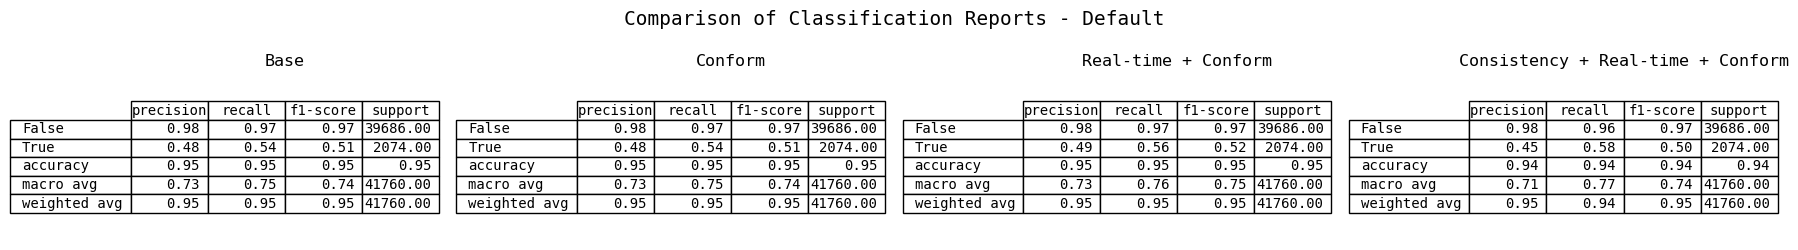

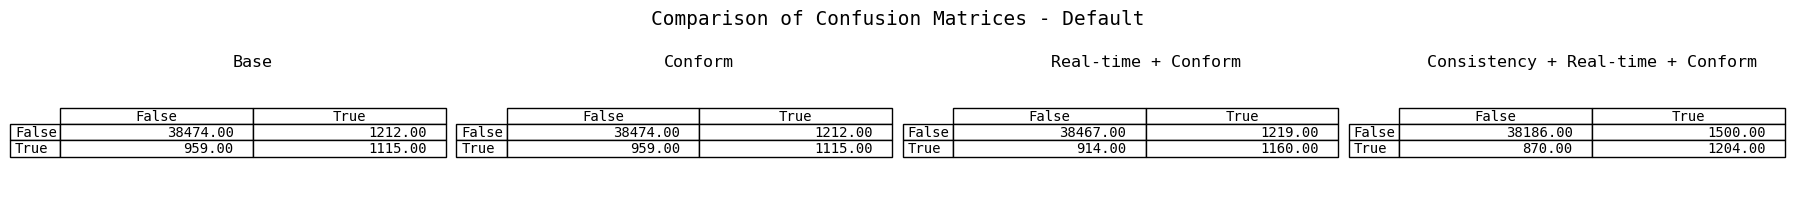

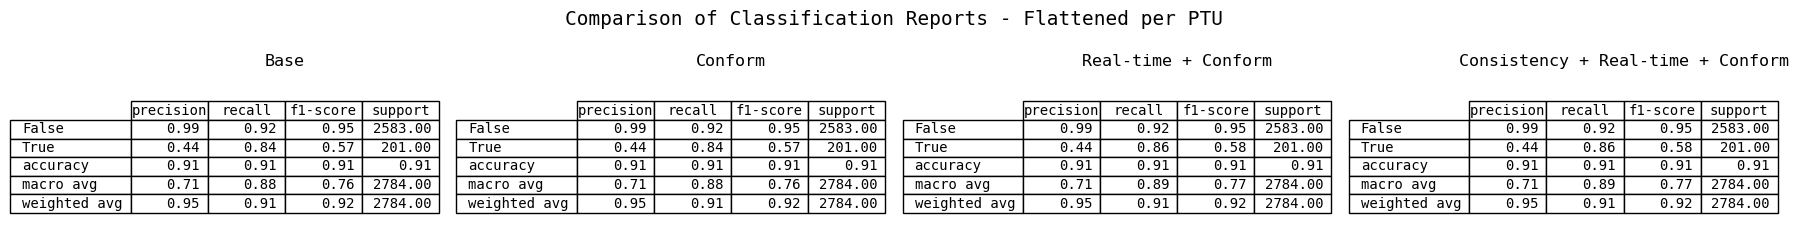

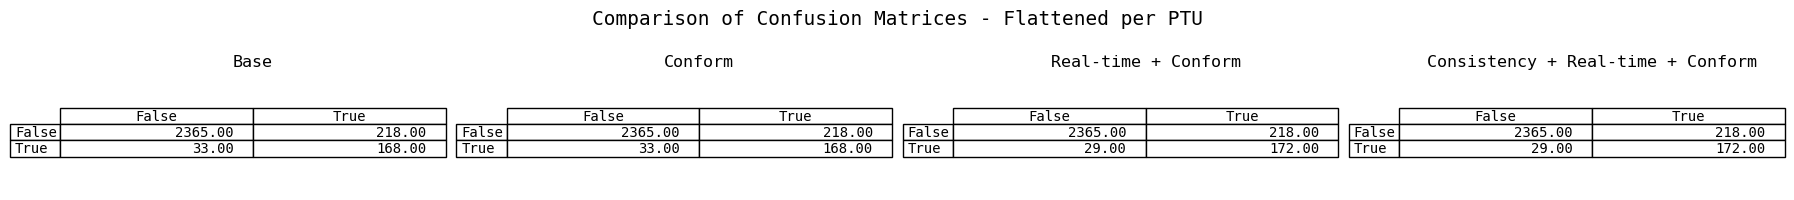

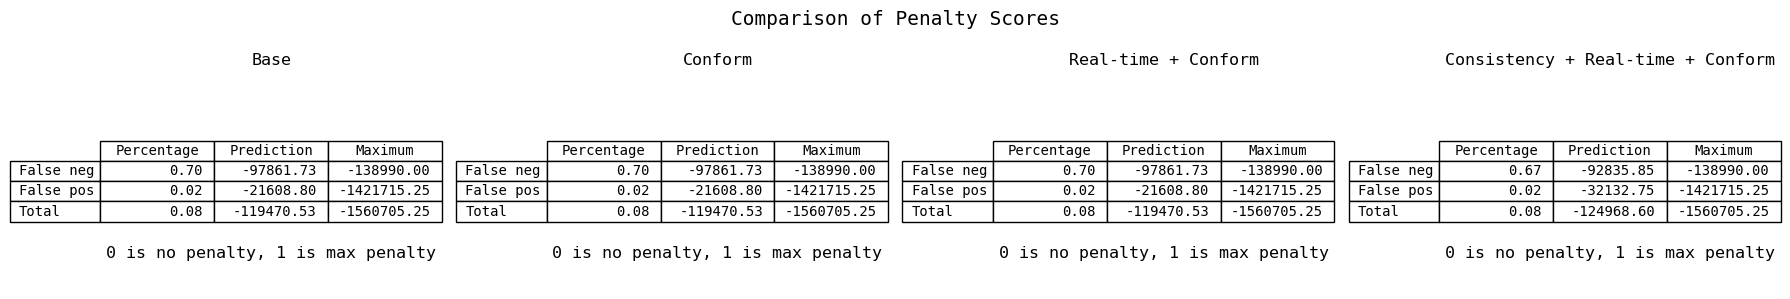

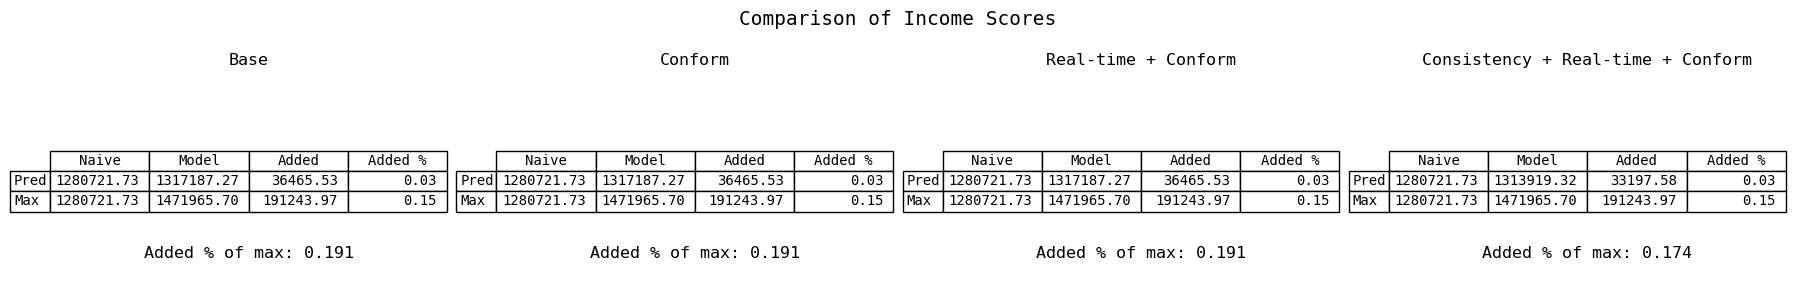

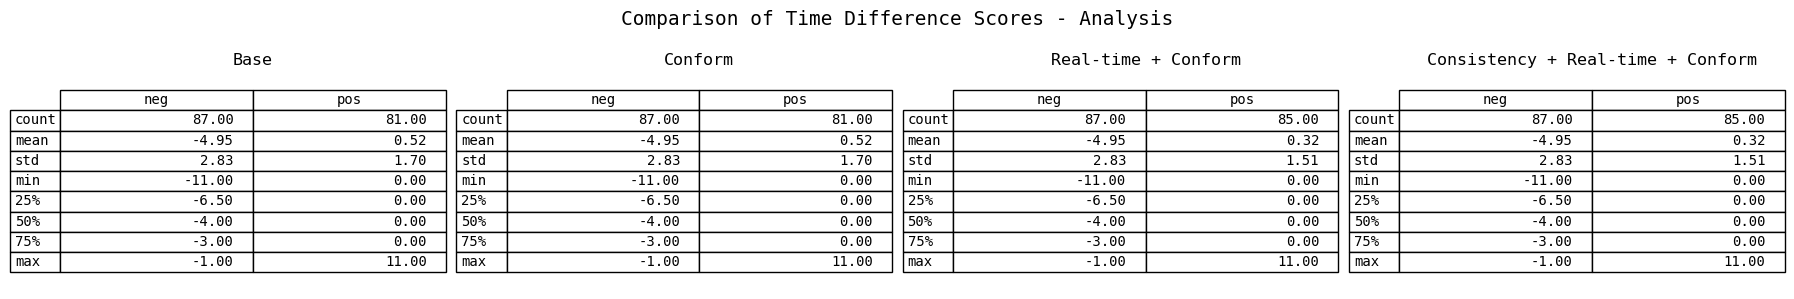

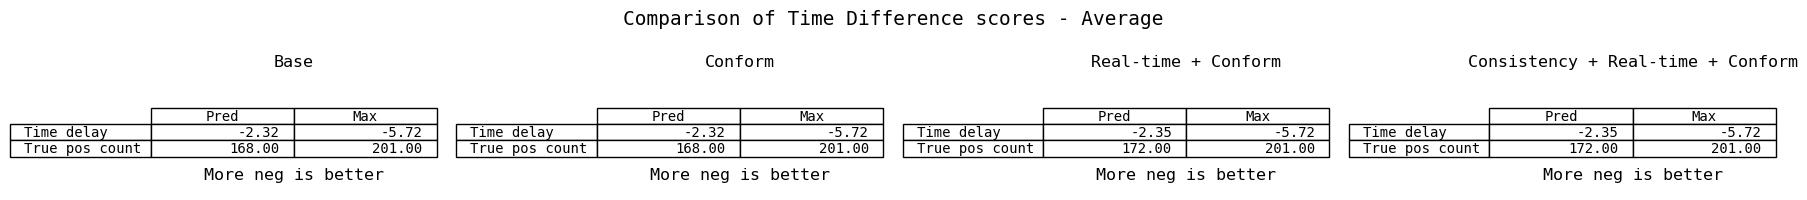

In [31]:
features = [
    "import_capacity",
    "min_price_published",
    "mid_price_published",
    "max_price_published",
    "min_ptu_price_known",
    "max_ptu_price_known",
    "time_since_last_two_sided",
    "two_sided_daily_count",
    "PTU",
    "naive_strategy_action",
    "vwap_avg",
    "vwap_std",
    "vwap_median",
    "vwap_qty_sum",
    "hvq_delta",
    "forecast_wind",
    "forecast_solar",
    "forecast_demand",
    'residual_load',
    'forecast_solar_delta',
    'forecast_wind_delta',
    'downward_dispatch_diff',
    'downward_dispatch_diff_2',
    'downward_dispatch_diff_3',
    'igcc_down_diff',
    'dispatch_diff',
    'igcc_diff',
    'import_zero',
    'import_capacity_left',
    'downward_dispatch_peak',
    'downward_dispatch_peak_time',
    'downward_dispatch_peak_diff',
    'upward_dispatch_peak',
    'upward_dispatch_peak_time',
    'upward_dispatch_peak_diff',
    'igcc_down_peak',
    'igcc_down_peak_time',
    'igcc_down_peak_diff',
    'igcc_up_peak',
    'igcc_up_peak_time',
    'igcc_up_peak_diff',
]
splits = get_splits(df, features, target, return_dict_pair=False)
# m = RandomForestClassifier(n_estimators=50)
# model = HistGradientBoostingRegressor(loss="poisson", l2_regularization=8, learning_rate=0.2, validation_fraction=0.5)



def train(train_in, train_out):
    model = HistGradientBoostingRegressor(loss="poisson", l2_regularization=8, learning_rate=0.2, validation_fraction=0.5)
    model.fit(train_in, train_out)
    return model


def test(model, test_in):
    pred = model.predict(test_in)
    return recast_pred(pred > 0.5)


best, _ = evaluate_income(train, test, splits[train_set][0], splits[train_set][1], splits[test_set][0], splits[test_set][3], repeat=50)

print(best[1])
p1 = test(best[0], splits[test_set][0])
show_metrics_adjusted(splits[test_set][3], p1, version=version)




# train on fix test on target
# split target and two side
# only check ptu start with neg or naive=true, for train or metric

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[False False False ... False False False]


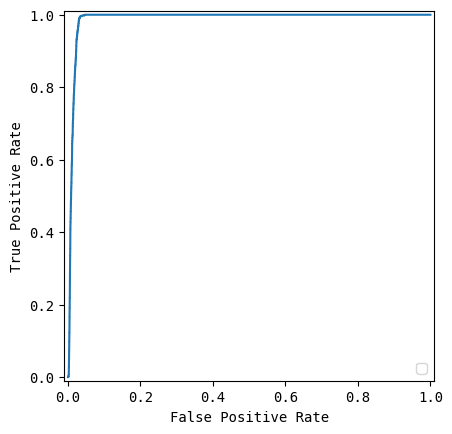

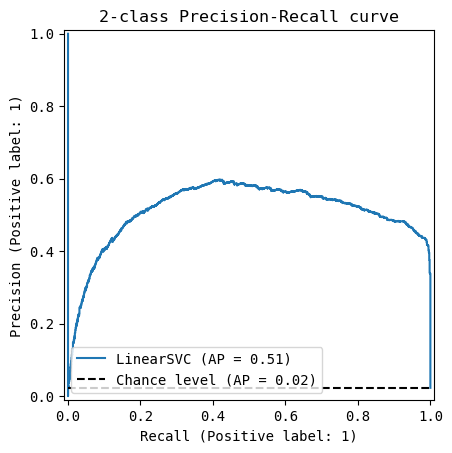

In [28]:
realtime = splits[test_set][3]['target_two_sided_ptu_realtime'].to_numpy(copy=True)

print(realtime)
fpr, tpr, thresholds = metrics.roc_curve(realtime, best[0].predict(splits[test_set][0]), pos_label=1)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

precision, recall, thresholds = metrics.precision_recall_curve(realtime, best[0].predict(splits[test_set][0]), pos_label=1)
display = metrics.PrecisionRecallDisplay.from_predictions(
    realtime, best[0].predict(splits[test_set][0]), name="LinearSVC", plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

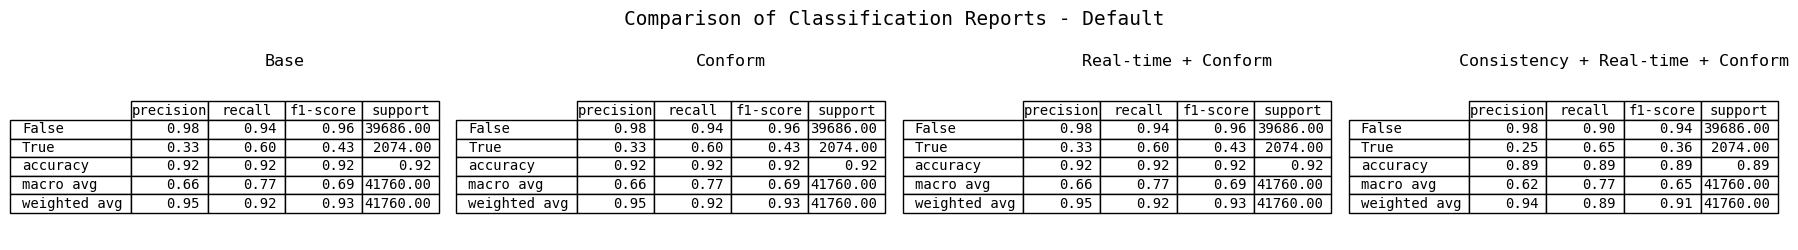

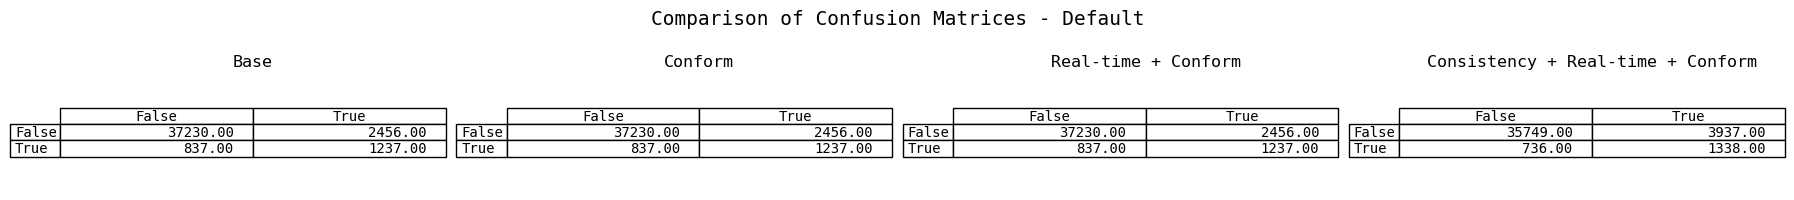

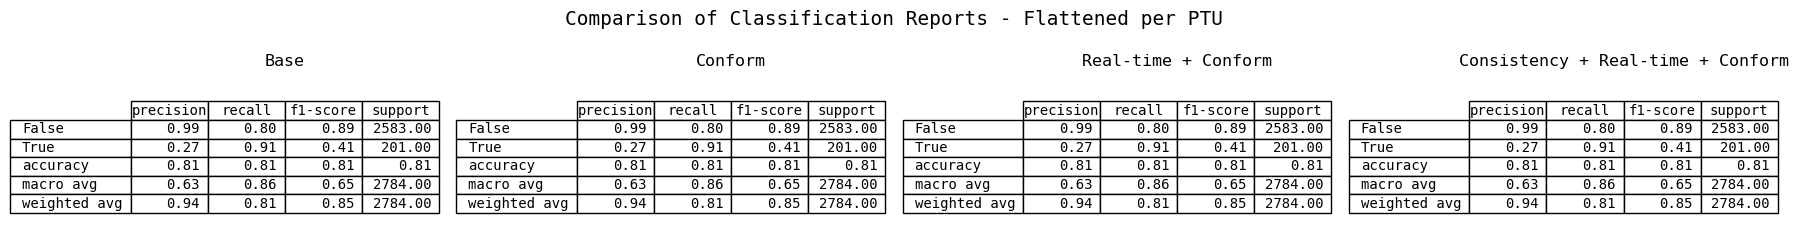

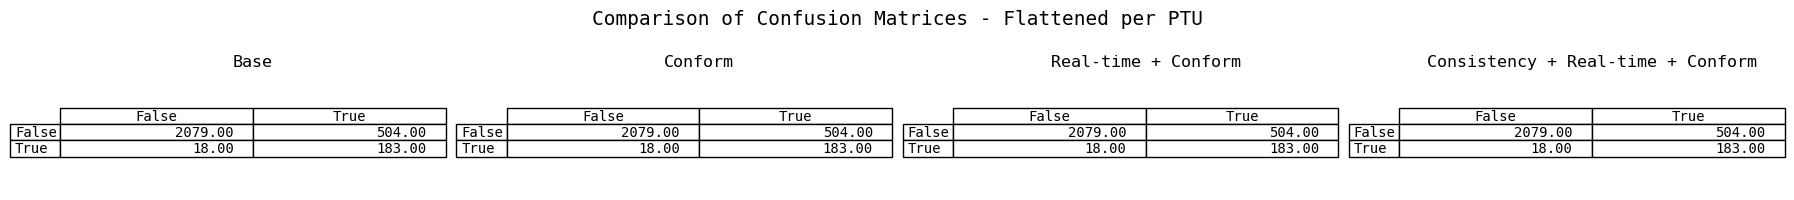

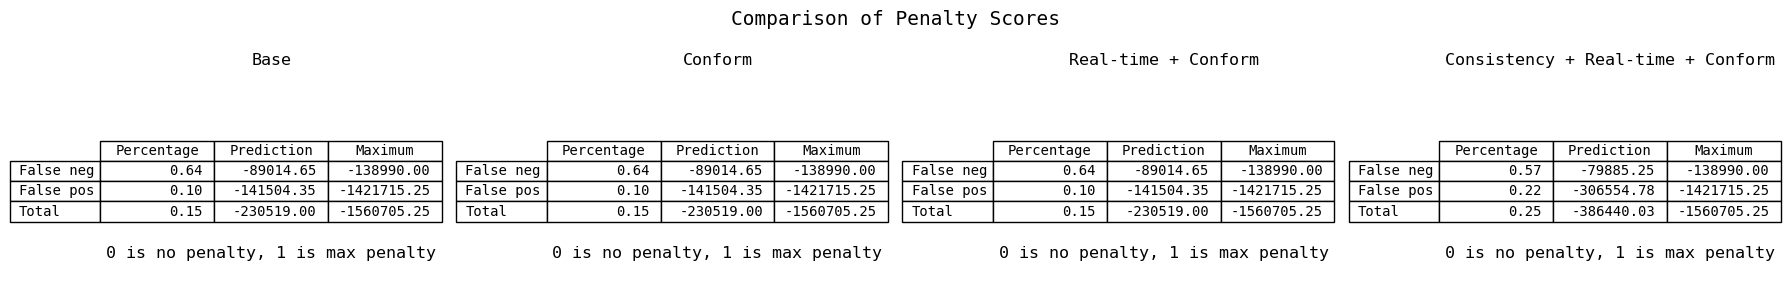

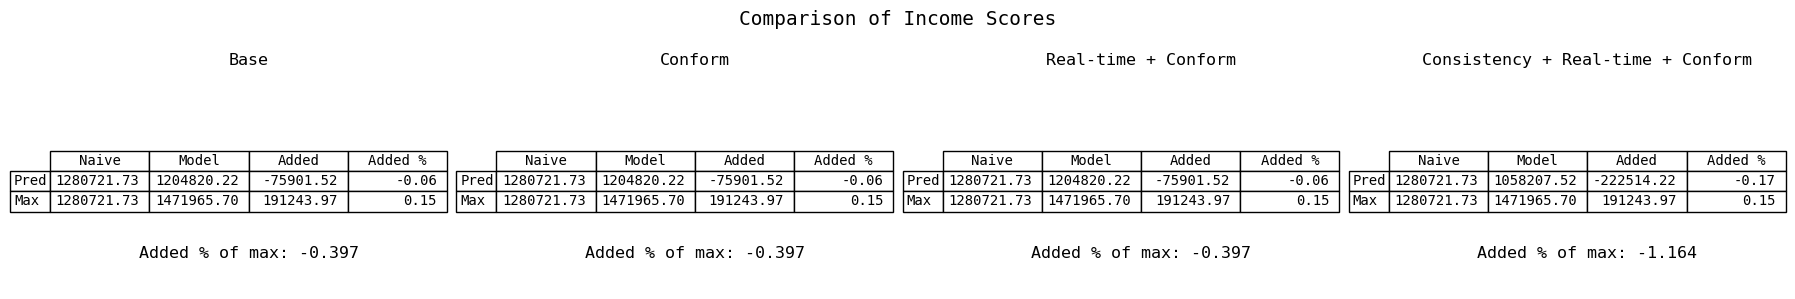

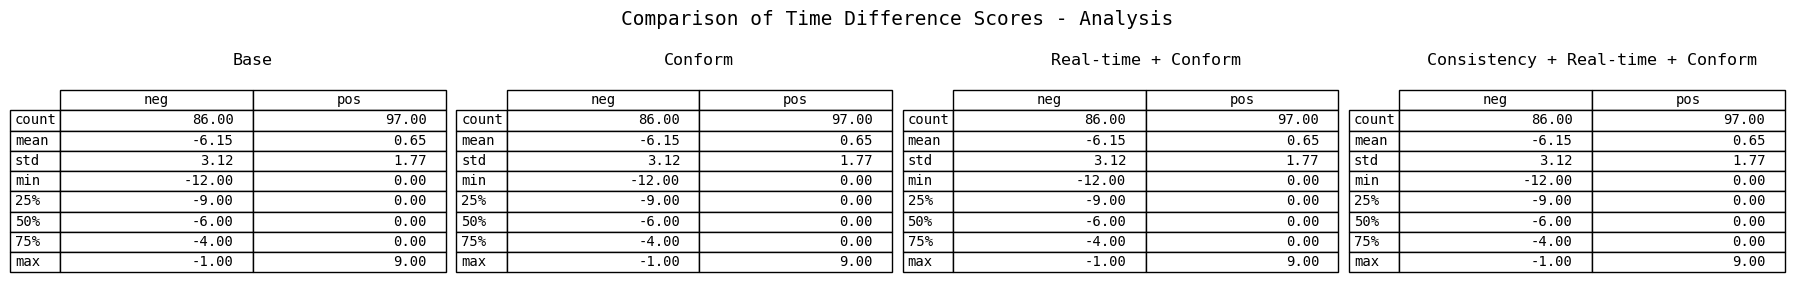

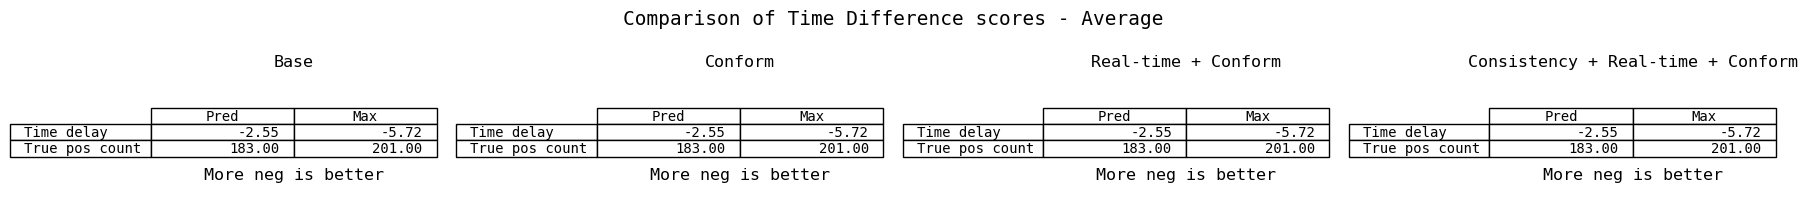

In [29]:
features = ["mid_price_published", "minute_in_ptu", "time_since_last_two_sided",
       "vwap_avg", "PTU", "forecast_demand", "ptu_id", "residual_load",
       "dispatch_diff", "igcc_diff"]
splits = get_splits(df, features, target, return_dict_pair=False)
# m = RandomForestClassifier(n_estimators=50)
# m = HistGradientBoostingRegressor(loss="poisson", l2_regularization=4)
m = HistGradientBoostingClassifier()
m.fit(splits[train_set][0], splits[train_set][1])
p = m.predict(splits[test_set][0])
# p = p > 0.5
p2 = recast_pred(p)
show_metrics_adjusted(splits[test_set][3], p2, version=version)

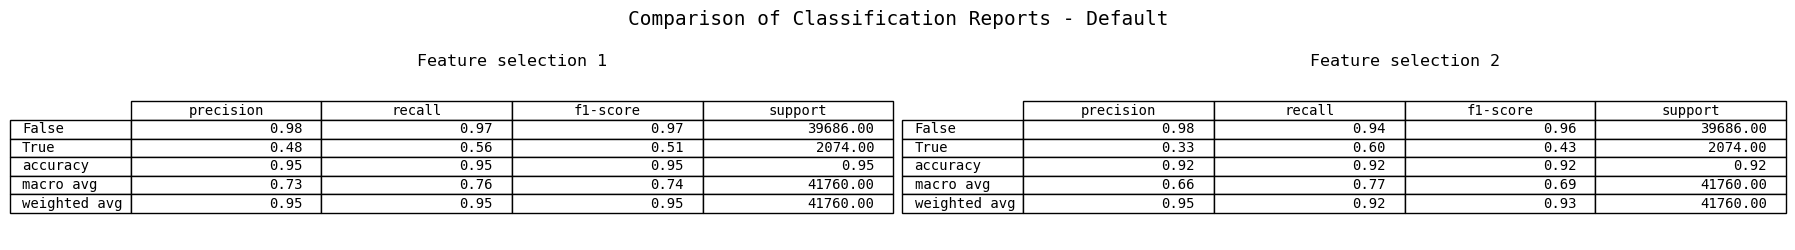

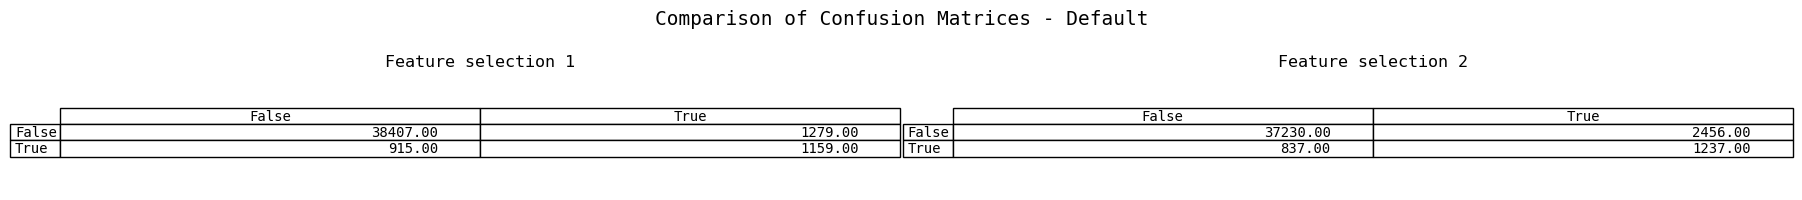

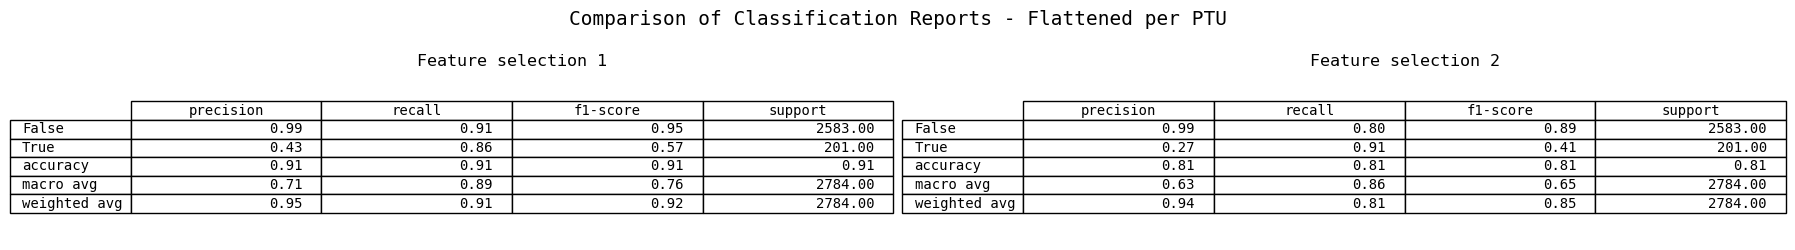

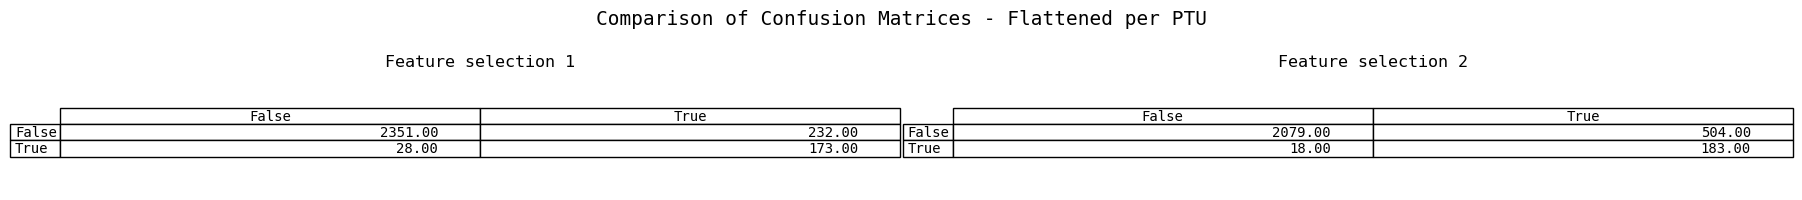

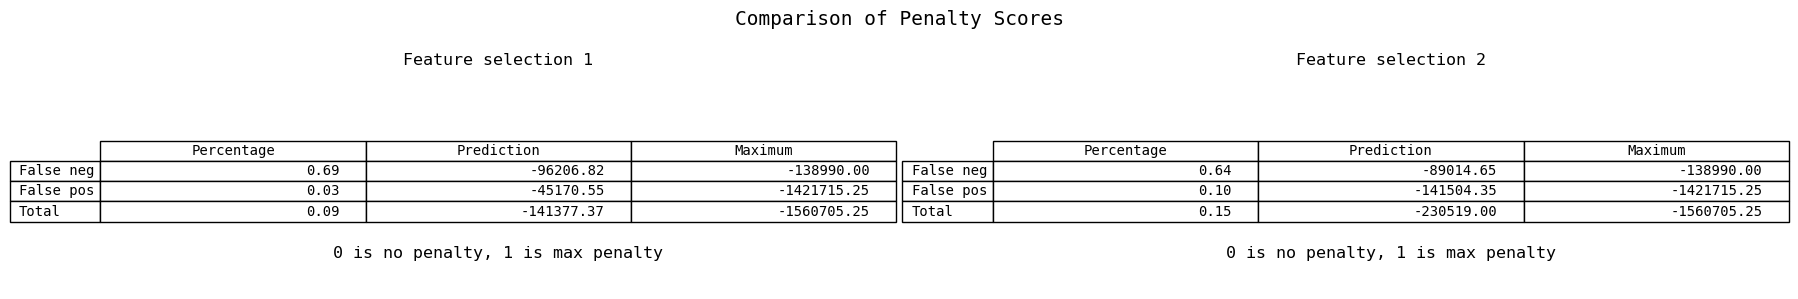

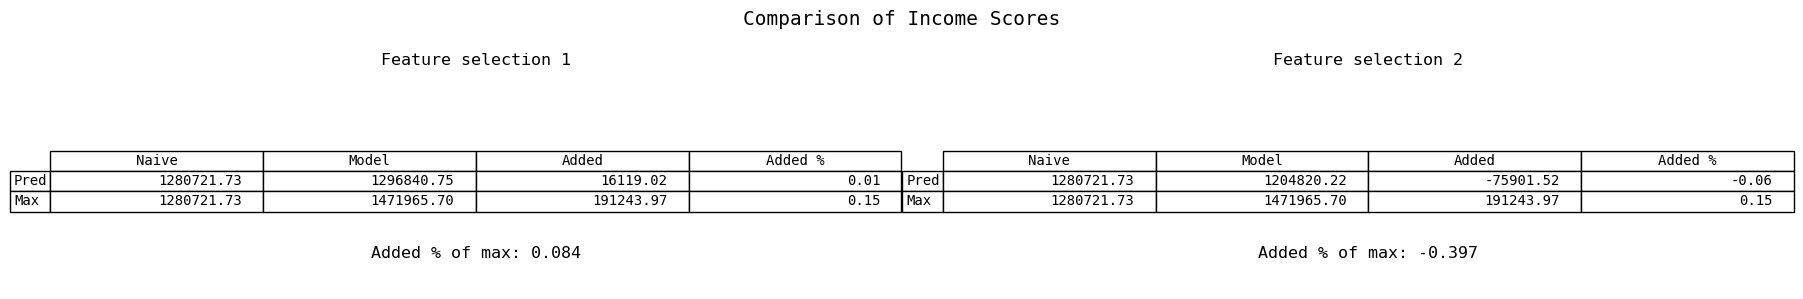

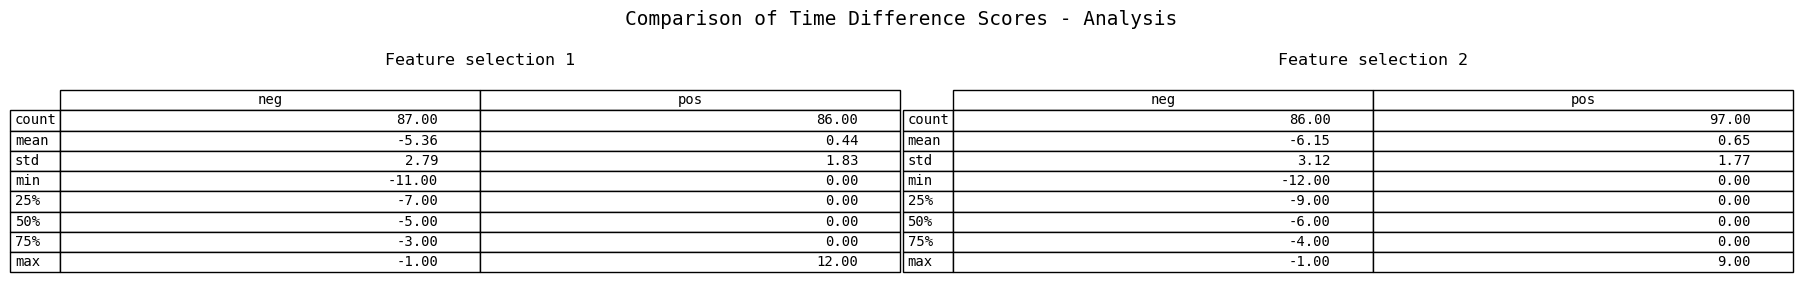

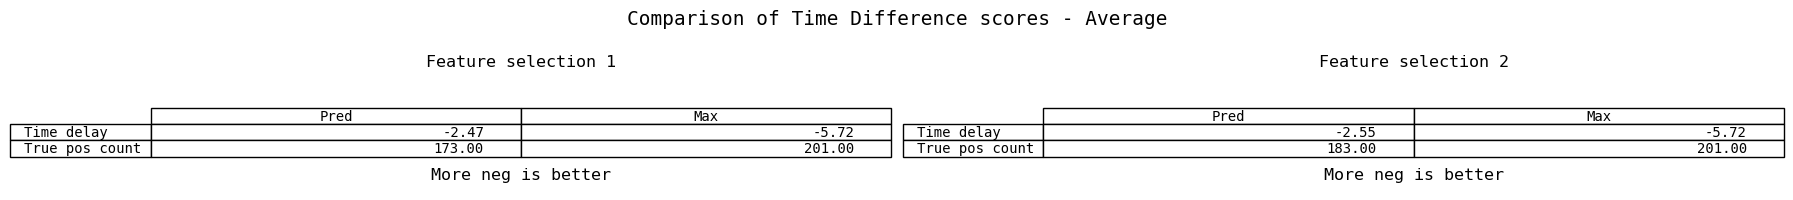

In [30]:
show_metrics_multi(splits[test_set][3], [p1, p2], titles=["Feature selection 1", "Feature selection 2"], version=version)